<a href="https://www.kaggle.com/code/atagnkrkmez/bootcamp-proje-ipynb?scriptVersionId=241817723" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-sales-data/car_prices.csv


# Amaç: 
**Araçların Özelliklerine Göre Fiyatının Tahmini**

Bu projede gözetimli öğrenme yöntemlerinden random forest regressor kullanılmıştır. Hiperparametre optimizasyonunda ise LightGBM kullanılmıştır. Araçların özelliklerine göre fiyat tahmini yapılmaktadır.

Veri seti ekleniyor.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("syedanwarafridi/vehicle-sales-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vehicle-sales-data


# 1. Kütüphanelerin Eklenmesi

In [3]:
#Kütüphaneler dahil ediliyor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder

In [4]:
#Veri seti ekleniyor
df = pd.read_csv('/kaggle/input/vehicle-sales-data/car_prices.csv')

# 2. Exploratory Data Analysis (Keşifsel Veri Analizi)

Aşağıda datasetin genel özellikleri açıklanmıştır.

In [5]:
#Satır ve sütun boyutu görüntüleme
df.shape

(558837, 16)

In [6]:
#Sütun isimlerini,veri tipleri,eksik veri varlığı
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [7]:
#Veri setinin ilk 5 satırı
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [8]:
#Son 5 satır
df.tail()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
558832,2015,Kia,K900,Luxury,Sedan,NaN,knalw4d4xf6019304,in,45.0,18255.0,silver,black,avis corporation,35300.0,33000.0,Thu Jul 09 2015 07:00:00 GMT-0700 (PDT)
558833,2012,Ram,2500,Power Wagon,Crew Cab,automatic,3c6td5et6cg112407,wa,5.0,54393.0,white,black,i -5 uhlmann rv,30200.0,30800.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT)
558834,2012,BMW,X5,xDrive35d,SUV,automatic,5uxzw0c58cl668465,ca,48.0,50561.0,black,black,financial services remarketing (lease),29800.0,34000.0,Wed Jul 08 2015 09:30:00 GMT-0700 (PDT)
558835,2015,Nissan,Altima,2.5 S,sedan,automatic,1n4al3ap0fc216050,ga,38.0,16658.0,white,black,enterprise vehicle exchange / tra / rental / t...,15100.0,11100.0,Thu Jul 09 2015 06:45:00 GMT-0700 (PDT)
558836,2014,Ford,F-150,XLT,SuperCrew,automatic,1ftfw1et2eke87277,ca,34.0,15008.0,gray,gray,ford motor credit company llc pd,29600.0,26700.0,Thu May 28 2015 05:30:00 GMT-0700 (PDT)


In [9]:
#Veri setinin gözlem sayısı,ortalama,standart sapması,çeyrekleri,en büyük değeri
df.describe()

,year,condition,odometer,mmr,sellingprice
count,558837.000000,547017.000000,558743.000000,558799.000000,558825.000000
mean,2010.038927,30.672365,68320.017767,13769.377495,13611.358810
std,3.966864,13.402832,53398.542821,9679.967174,9749.501628
min,1982.000000,1.000000,1.000000,25.000000,1.000000
25%,2007.000000,23.000000,28371.000000,7100.000000,6900.000000
50%,2012.000000,35.000000,52254.000000,12250.000000,12100.000000
75%,2013.000000,42.000000,99109.000000,18300.000000,18200.000000
max,2015.000000,49.000000,999999.000000,182000.000000,230000.000000


# 3. Görsel Keşifsel Veri Analizi

Yıl, durum, kilometre sayacı, mmr ,satış fiyatları ve marka başına satış sayıları verilerinin görsel açıklamaları (grafik halinde).

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


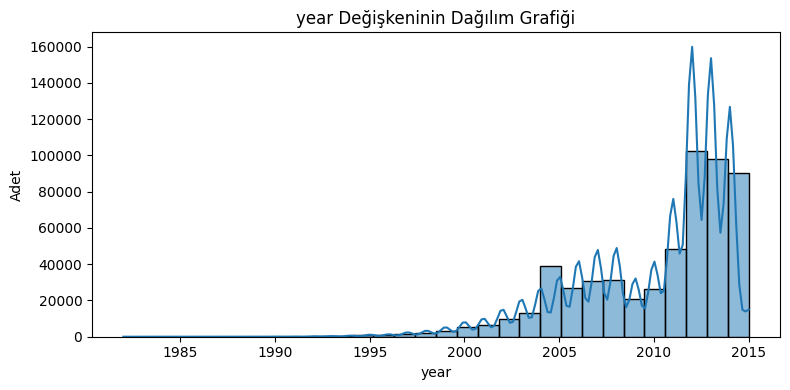

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


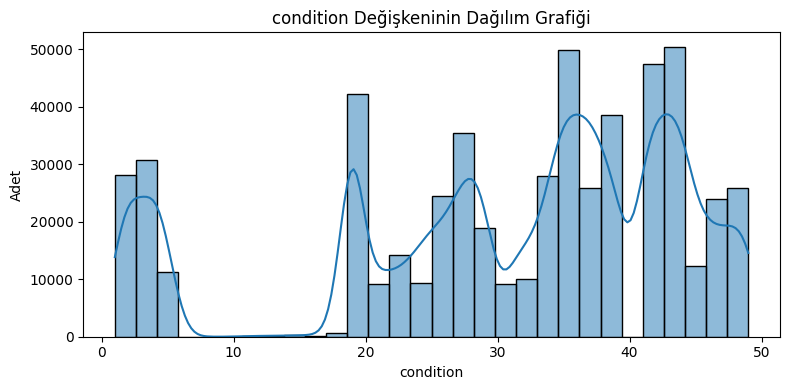

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


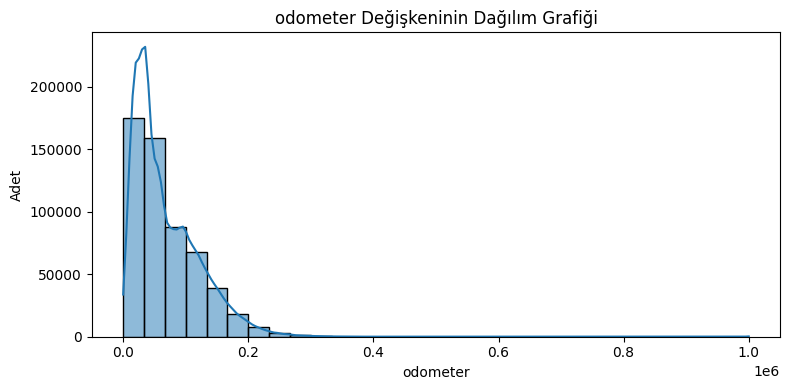

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


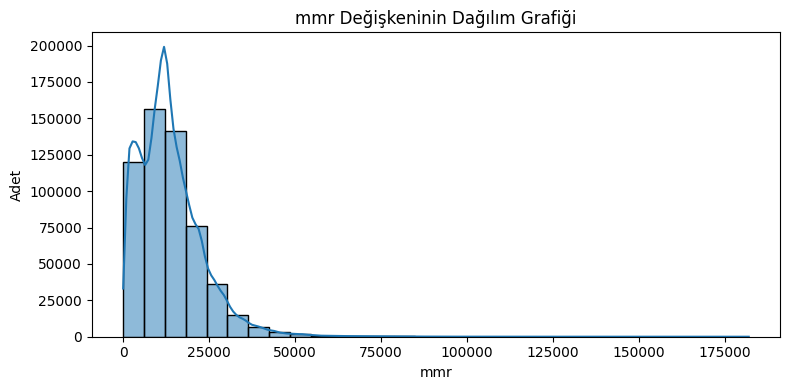

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


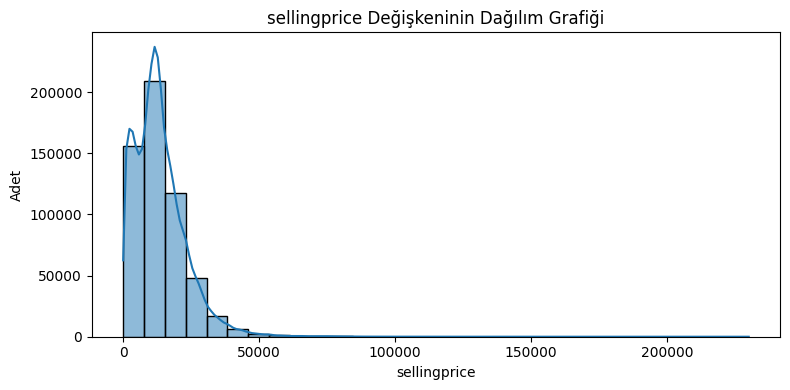

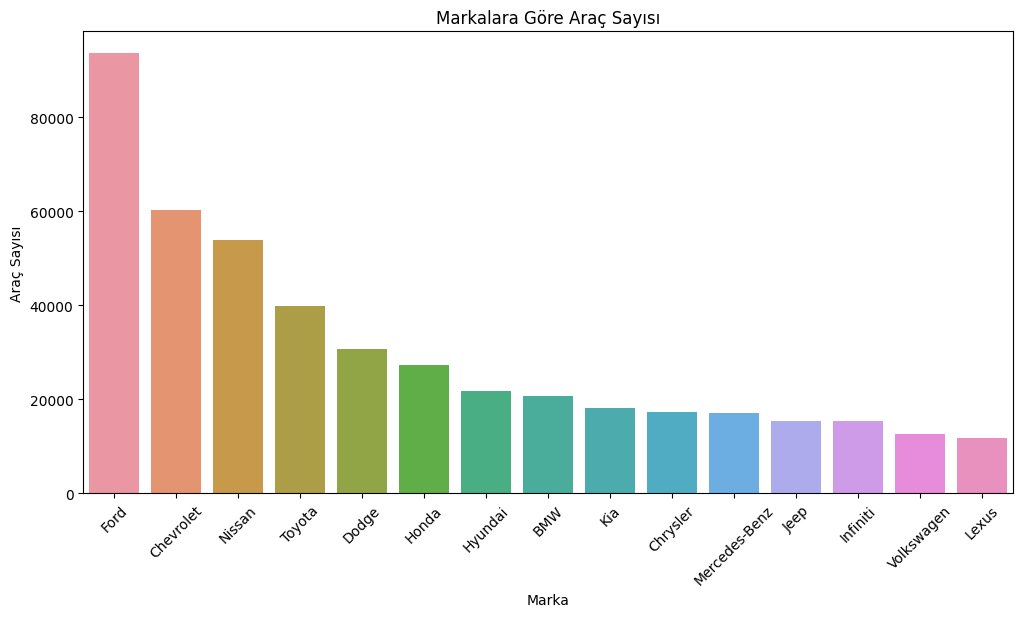

In [10]:
# Sayısal sütunlar seciliyor
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
# Seçilen sütunların yoğunluk ve değerlerinin görsel gösterimi
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'{col} Değişkeninin Dağılım Grafiği')
    plt.xlabel(col)
    plt.ylabel('Adet')
    plt.tight_layout()
    plt.show()
# En Çok Satılan ilk 15 Aracın Marka Bazında Grafiği
plt.figure(figsize=(12, 6))
sns.countplot(x="make", data=df, order=df["make"].value_counts().index[:15])
plt.xticks(rotation=45)
plt.title("Markalara Göre Araç Sayısı")
plt.xlabel("Marka")
plt.ylabel("Araç Sayısı")
plt.show()

# 4. Veri Önişleme (Preprocessing)

Bu kısımda elimizdeki veri setini işleme uygun hale getirecek düzenlemeler yapacağız.

In [11]:
df.isnull().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

Burada görülen eksik değerler üzerinde ; mmr, condition, odometer, sellingprice gibi sayısal alanlarda ortanca (median) ; color, body, interior gibi kategorik alanlarda unknown (bilinmeyen) kullanılarak eksik değerler doldurulabilir.

In [12]:
# Kategorik sütunlar için other değerleri doldurma
kategorik_other = ['make', 'model', 'trim', 'color']
df[kategorik_other] = df[kategorik_other].fillna('Other')

kategorik_mod = ['body', 'transmission', 'interior']
for col in kategorik_mod:
    df[col] = df[col].fillna(df[col].mode()[0])

# Sayısal sütunlar için ortalama ile doldurma
sayisal = ['condition', 'odometer', 'mmr']
df[sayisal] = df[sayisal].fillna(df[sayisal].mean())

# Gereksiz sütunları silme 
df.dropna(subset=['vin', 'saledate'], inplace=True)

In [13]:
df.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

Sonuç olarak eksik veriler sorun oluşturmayacak şekilde değiştirilmiş veya silinmiştir.

# 4.1 Veri Setlerini Hazırlama

Bu aşamada tahmin edilecek olan değişken ve onu tahmin etmemizi sağlayacak değişkenlerin ayrımı yapılıyor. 

In [14]:
#Tekrar eden sütun tespiti
df.duplicated().sum()

0

Tekrar eden sütun yoktur.

**Tahmin Edilecek Değişkenin ve Tahmin Etmede Yararlanacağımız Değişkenlerin Ayrımı:**

In [15]:
df_new=df[["year","make","model","body","transmission","odometer","color","interior","sellingprice"]]

Y=df_new["sellingprice"]
X=df_new.drop("sellingprice",axis=1)

**Label Encoding:**

Makine öğreniminde kullandığımız algoritma string değerleri tanımayacaktır. Bu nedenle bunların sayılsa değerlere çevrilmesi gereklidir. Bu ise aşağıdaki kod bloğunda sağlanır.

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
kategorik_stn = ["make", "model", "body", "transmission", "color", "interior"]
for col in kategorik_stn:
    X[col] = label_encoder.fit_transform(X[col])

**Ölçeklendirme:**

Burada performansı arttırmak için ölçeklendirme işlemi yapıyoruz.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Modeli Eğitme

Model olarak random regression trees tercih ettim. Bunun sebeplerini açıklamak gerekirse:
* Araba fiyatları; marka, model, km, yaş gibi faktörler farklı ve doğrusal olmayan etkiler içerir. Bu durumlarda Random Regression Trees daha kullanışlıdır.
* Aykırı değerlere karşı direnç yüksektir çünkü birden fazla tree nin ortalaması alınır.
* Overfitting'e karşı dirençlidir.
* Diğer alternatiflere kıyasla probleme daha uygundur ve R^2 değeri yüksektir

**Test ve Eğitim Verilerinin Ayrımı:**

In [18]:
from sklearn.model_selection import train_test_split

# Eğitim ve test setine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

**Modelin Eğitimi:**

Bu aşamada modelin tanımlaması yapılıyor. Model 100 ağaç kullanacaktır ve rastgeleliği sabitlenmiştir. Ardından ise R kare skoru ve Hata Kare değerini yazdırıp başarılı olup olmadığını görmüş oluruz.

In [19]:
from sklearn.ensemble import RandomForestRegressor

# Modeli oluşturma
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Modeli eğitme
rf_model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score

# Test seti üzerinde tahminler
y_pred = rf_model.predict(X_test)

# R^2 Skoru
r2 = r2_score(y_test, y_pred)
print(f"R^2 Skoru: {r2}")

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE Değeri: {mse}")

R^2 Skoru: 0.9177311537988967
MSE Değeri: 7845207.282411405


# 6. Hiperparametre Optimizasyonu

LightGBM seçme nedenlerim: 
* 3 katlı çapraz doğrulama ile modelin performansını ölçmek.
* Hızlı oluşu.
* Kaggle'da düzenlenen regresyon temalı etkinliklerde sıkça kullanılması.

In [20]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

# Varsayılan parametrelerle hızlı model
lgbm = LGBMRegressor(random_state=42, verbose=-1)

# Çapraz doğrulama R² skoru
scores = cross_val_score(lgbm, X_train, y_train, cv=3, scoring='r2')
print(f"Ortalama R²: {np.mean(scores):.3f}")

# Hızlı hiperparametre optimizasyonu
param_grid = {
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(lgbm, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("En iyi parametreler:", grid_search.best_params_)

Ortalama R²: 0.862
En iyi parametreler: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 63}


# 7. Son Değerlendirme

Bu aşamada ortalama kare hata, kök ortalama kare hata, ortalama mutlak hata değerleri test edilmiştir.

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Ortalama Kare Hata MSE:", mean_squared_error(y_test, y_pred))
print("Kök Ortalama Kare Hata RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Ortalama Mutlak Hata MAE:", mean_absolute_error(y_test, y_pred))

Ortalama Kare Hata MSE: 7845207.282411405
Kök Ortalama Kare Hata RMSE: 2800.929717506565
Ortalama Mutlak Hata MAE: 1731.1139664169932


Kullanılan yöntemler ile proje tatmin edici bir başarı oranına ulaşmıştır.